In [13]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

In [14]:
data = np.load("processed_data.npz")

In [15]:
# used for gym environment
np.savez("sepsis_starting_states.npz", sepsis_starting_states = data['x_test'])

In [16]:
data.files

['x_train', 'y_train', 'x_test', 'y_test']

In [17]:
data['x_train'].shape

(153582, 47)

In [18]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx][:-1],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [19]:
train_matrix = get_padded_matrix( data['x_train'],  data['y_train'])

In [20]:
test_matrix = get_padded_matrix( data['x_test'],  data['y_test'])

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_matrix.shape[2]-1)
])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                19600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                5934      
Total params: 32,062
Trainable params: 32,062
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/lstm_no_embed{}".format(time()))
model.fit(train_matrix, data['y_train'], validation_data=(test_matrix, data['y_test']), epochs=10, callbacks=[tensorboard])

Train on 153582 samples, validate on 39232 samples
Epoch 1/10
153582/153582 [==============================] - 55s 361us/step - loss: 0.1776 - val_loss: 0.1215
Epoch 2/10
153582/153582 [==============================] - 57s 371us/step - loss: 0.1396 - val_loss: 0.1183
Epoch 3/10
153582/153582 [==============================] - 54s 352us/step - loss: 0.1370 - val_loss: 0.1175
Epoch 4/10
153582/153582 [==============================] - 55s 357us/step - loss: 0.1360 - val_loss: 0.1170
Epoch 5/10
153582/153582 [==============================] - 54s 350us/step - loss: 0.1351 - val_loss: 0.1160
Epoch 6/10
153582/153582 [==============================] - 60s 389us/step - loss: 0.1346 - val_loss: 0.1152
Epoch 7/10
153582/153582 [==============================] - 100s 650us/step - loss: 0.1343 - val_loss: 0.1164
Epoch 8/10
153582/153582 [==============================] - 64s 415us/step - loss: 0.1340 - val_loss: 0.1150
Epoch 9/10
153582/153582 [==============================] - 57s 374us/step -

In [17]:
# save for gym env
model.save('sepsis_states.model')

In [11]:
model = keras.models.load_model('sepsis_states.model')

In [26]:
test_predicted = model.predict(test_matrix)

In [27]:
train_predicted = model.predict(train_matrix)

In [28]:
columns = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive']

In [29]:
test_predicted[0:11,columns.index('HeartRate')]

array([-0.8131276 , -0.5656373 , -0.5300242 , -0.4675593 , -0.47409707,
       -0.48206553, -1.2295566 , -1.0365493 , -1.1201013 , -1.0026877 ,
       -0.9422834 ], dtype=float32)

In [32]:
sns.set(style="white")

def plot(column, mode="test", prediction=test_predicted):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['y_'+mode][6:24,columns.index(column)], label="truth")
    plt.plot(prediction[6:24,columns.index(column)], label="predicted")
    plt.legend(["Real Value", "Predicted Value"])
    plt.title(column + " " + mode)
    plt.show()

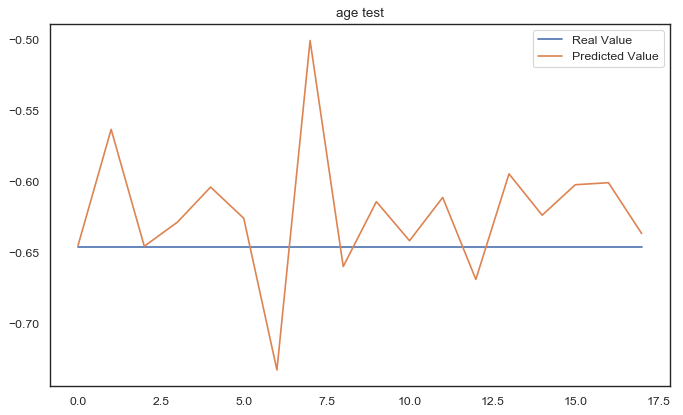

In [34]:
plot("age", "test", test_predicted)

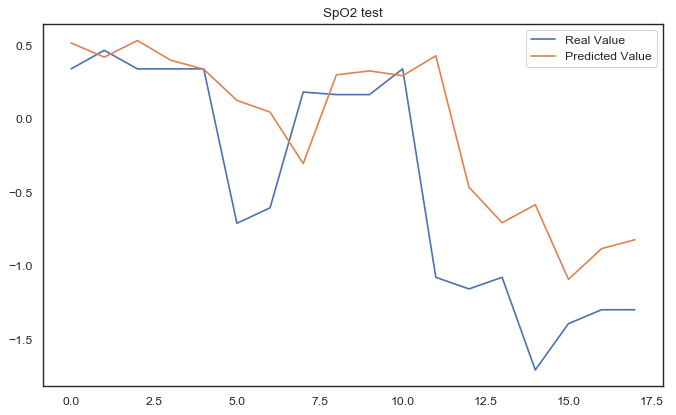

In [33]:
plot("SpO2", "test", test_predicted)

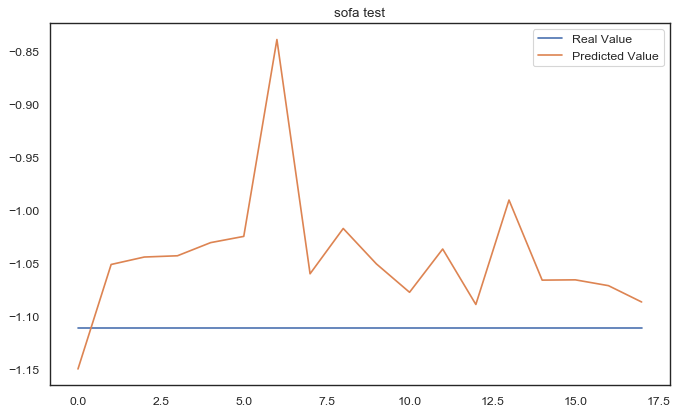

In [35]:
plot("sofa")

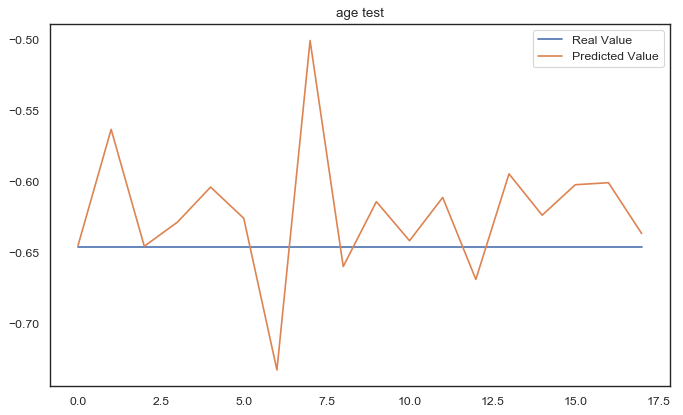

In [36]:
plot("age")

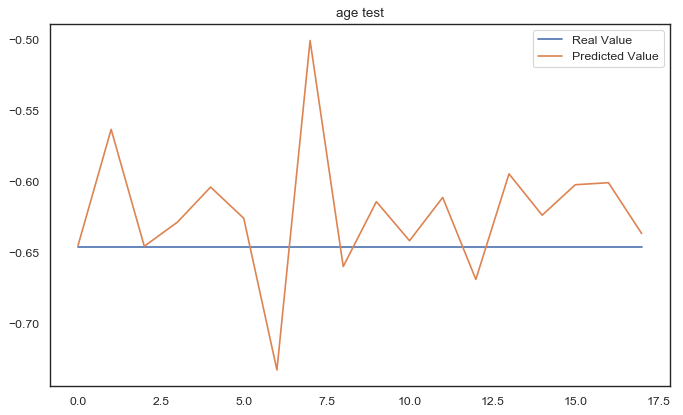

In [42]:
plot("age")

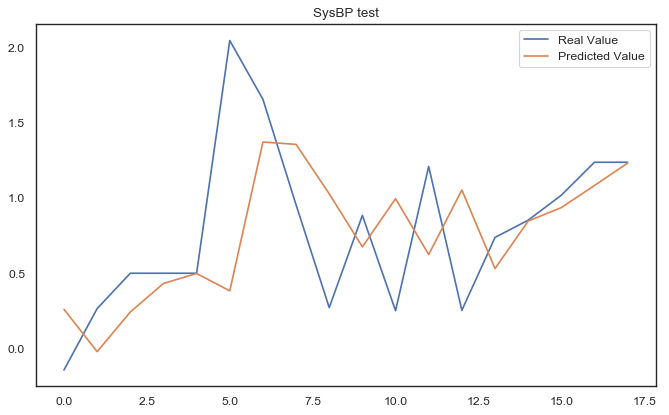

In [38]:
plot("SysBP")

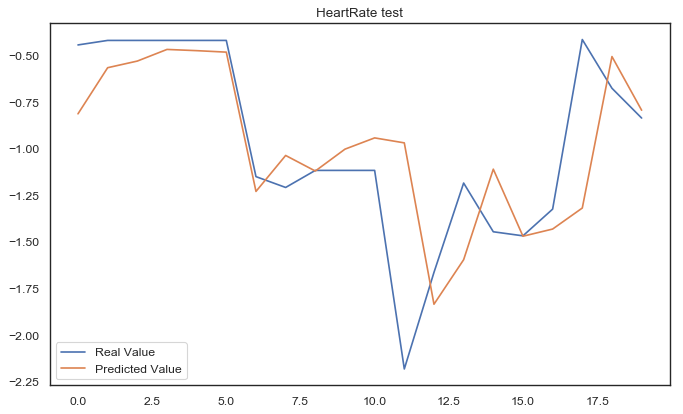

In [28]:
plot("HeartRate")

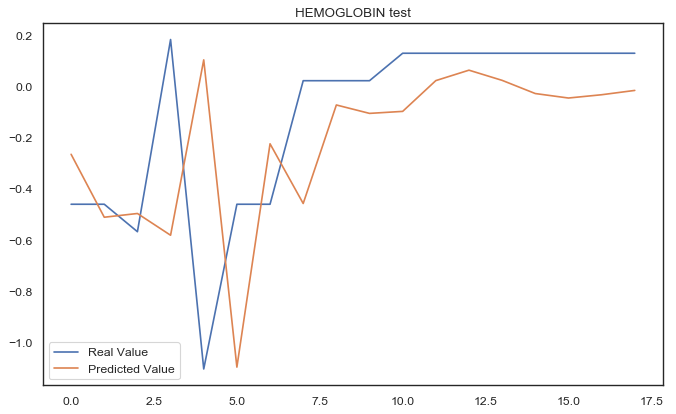

In [39]:
plot("HEMOGLOBIN")

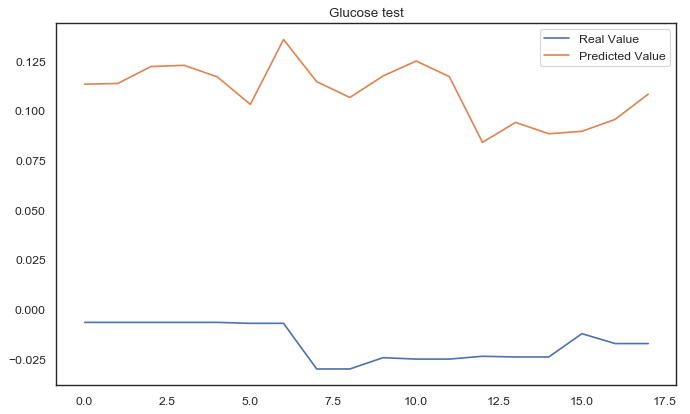

In [40]:
plot("Glucose")